# Train 

This file is used for training the machine learning model and generating the 'weights.json' file.  

You should not need to run or accelerate anything in this file.  It is here for documentation purposes only!
.

In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import truncnorm

In [2]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "./data/"
train_data = pd.read_csv(data_path + "mnist_train.csv", delimiter=",").values
test_data = pd.read_csv(data_path + "mnist_test.csv", delimiter=",").values


In [3]:
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:], dtype=np.float32) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:], dtype=np.float32) * fac + 0.01
train_imgs = train_imgs.reshape(train_imgs.shape[0], 1, train_imgs.shape[1])
test_imgs = test_imgs.reshape(test_imgs.shape[0], 1, test_imgs.shape[1])

train_labels = np.asfarray(train_data[:, :1], dtype=np.float32)
test_labels = np.asfarray(test_data[:, :1], dtype=np.float32)

lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float32)
test_labels_one_hot = (lr==test_labels).astype(np.float32)

# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot==0] = 0.001
train_labels_one_hot[train_labels_one_hot==1] = 0.999
test_labels_one_hot[test_labels_one_hot==0] = 0.001
test_labels_one_hot[test_labels_one_hot==1] = 0.999

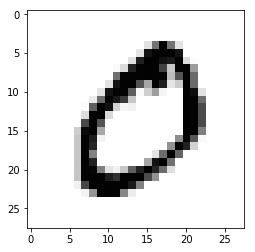

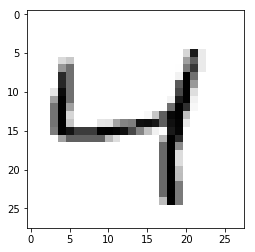

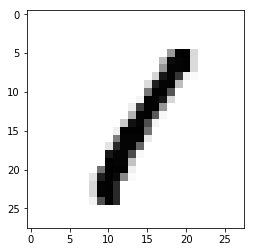

In [4]:
for i in range(3):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

# Code adapted from:

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

In [5]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [6]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [7]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [13]:
class TanhLayer(ActivationLayer):
    # static
    e = 2.71828182845904523536028747135266249775724709369995
    
    #http://www.plunk.org/~hatch/rightway.php
    #https://math.stackexchange.com/questions/518758/alternative-form-for-sinhx-coshx
    @staticmethod
    def tanh(x):   
        e = TanhLayer.e
        return (1 - e ** (-2 * x)) / (1 + e ** (-2 * x)) 
        #return (1-np.exp(-2 * x))/(1+np.exp(-2 * x))

    @staticmethod
    def tanh_prime(x):
        return 1-TanhLayer.tanh(x)**2
    
    def __init__(self):
        super(TanhLayer,self).__init__(self.tanh, self.tanh_prime)
    
class NpTanhLayer(ActivationLayer):
    def __init__(self):
        super(NpTanhLayer,self).__init__(np.tanh, self.tanh_prime)
    
    @staticmethod
    def tanh_prime(x):        
        return 1-np.tanh(x)**2;    

In [14]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [15]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
    
    def save(self, fname):
        import pickle
        with open(fname, "bw") as fh:
            pickle.dump(self, fh)

    @classmethod
    def load(cls, fname):
        import pickle
        with open(fname, "br") as fh:
            return pickle.load(fh)

In [23]:
# Network
net = Network()
net.use(mse, mse_prime)
net.add(FCLayer(train_imgs.shape[2], 80))
net.add(TanhLayer())
net.add(FCLayer(80, 40)) 
net.add(TanhLayer())
net.add(FCLayer(40, 20)) 
net.add(TanhLayer())
net.add(FCLayer(20, train_labels_one_hot.shape[1]))

In [24]:
#Do NOT DO THIS ON THE PYNQ!
net.fit(train_imgs,train_labels_one_hot, epochs=5, learning_rate=0.1)
net.fit(train_imgs,train_labels_one_hot, epochs=5, learning_rate=0.01)
net.fit(train_imgs,train_labels_one_hot, epochs=5, learning_rate=0.001)

epoch 1/5   error=0.026806
epoch 2/5   error=0.013058
epoch 3/5   error=0.010238
epoch 4/5   error=0.008642
epoch 5/5   error=0.007529
epoch 1/5   error=0.005223
epoch 2/5   error=0.004887
epoch 3/5   error=0.004738
epoch 4/5   error=0.004619
epoch 5/5   error=0.004515
epoch 1/5   error=0.004330
epoch 2/5   error=0.004300
epoch 3/5   error=0.004286
epoch 4/5   error=0.004274
epoch 5/5   error=0.004263


In [25]:
def evaluate(net, data, labels):
    corrects, wrongs = 0, 0
    for i in range(len(data)):
        res = np.array(net.predict(data[i]))
        res = res.argmax()
        if res == labels[i]:
            corrects += 1
        else:
            wrongs += 1
    return corrects, wrongs

In [26]:
corrects, wrongs = evaluate(net, train_imgs, train_labels)
print("accruracy train: ", corrects / ( corrects + wrongs))

accruracy train:  0.9741995699928332


In [27]:
corrects, wrongs = evaluate(net, test_imgs, test_labels)
print("accruracy train: ", corrects / ( corrects + wrongs))

accruracy train:  0.9565956595659566


In [28]:
net.save('network.pkl')